# Dielectric waveguides: interactive lecture and p-set


## P-set: Dielectric waveguides
In this p-set you will design some of the basic components of a photonic integrated circuit. You will start by designing a waveguide cross-section of your choice, and then build on top of that to make directional couplers, mach-zehnder interferometers (MZIs), and grating couplers.

### Problem 1: Make your own waveguide
In the first part of this p-set you will solve analytically for the modes in symmetric dielectric slab waveguides, and write a code that lets you solve for different polarizations and geometrical and optical parameters. Then, you will select a material, wavelength, and waveguide geometry of your choice for the following problems.

#### P-1a: Analytically simulate a slab waveguide, plot the E and H fields distribution, and calculate number of modes and effective mode indices
Make a function that inputs your refractive index profile (nc, ncladtop, ncladbot), your wavelength (wavel), the thickness of your slab (d), and the polarization to solve for (pol='TE' or 'TM').
The function should output the number of modes, mode indices, and the relevant E and H fields.

To troubleshoot if your results are correct, you can compare your effective mode index and field profiles to the output of this online 2D variational effective index approximation solver https://www.computational-photonics.eu/eims.html, just make sure your waveguide width is large enough to approximate an infinite slab, and that you're looking at the right mode!

In [36]:
import numpy as np
from numpy.lib import scimath as sm
import matplotlib.pyplot as plt
from ipywidgets import interactive
from scipy.signal import find_peaks
import scipy.constants as sciconst

Number of modes = 2


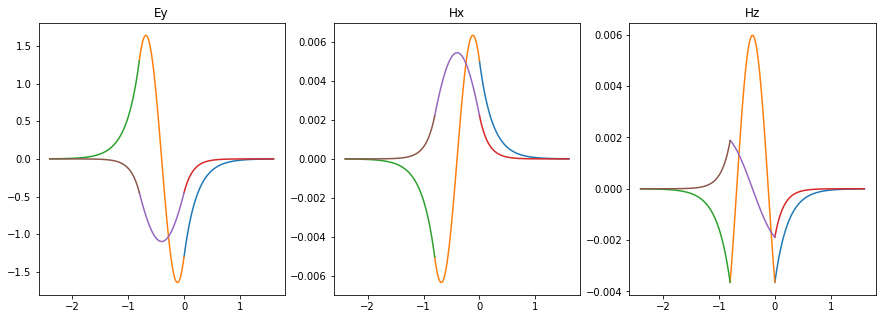

array([1.45445445, 1.86986987])

In [40]:
plottest=False
def slab(nc, ncladtop, ncladbot, wavel, d, pol='TE', plot=True): 
    # Wavelength and distance in um
    n1=nc
    n3=ncladbot
    n2=ncladtop
    wavel=wavel*1e-6
    d=d*1e-6
    k0=2*np.pi/wavel
    omega=k0*sciconst.c
    beta=np.linspace(min(n1,n2,n3),max(n1,n2,n3),num=1000)*2*np.pi/wavel
    
    delta=sm.sqrt(beta**2-n3**2*k0**2)
    kappa=sm.sqrt(n1**2*k0**2-beta**2)
    gamma=sm.sqrt(beta**2-n2**2*k0**2)
    
    left=np.tan(kappa*d)
    if pol=='TE':
        right=kappa*(gamma+delta)/(kappa**2-gamma*delta)
    elif pol=='TM':
        right=kappa*(gamma*n1**2/n2**2+delta*n1**2/n3**2)/(kappa**2-gamma*n1**2/n2**2*delta*n1**2/n3**2)
    fun=-abs(left-right)
    peaks=find_peaks(fun)
    
    # Calculate number of modes
    v=np.real(k0*d*np.sqrt(n1**2-n2**2))
    M=1+int(v/np.pi)
    print('Number of modes = '+ str(M))
    
    if plottest==True:
        plt.figure(1)
        plt.plot(beta*wavel/np.pi/2,left, beta*wavel/np.pi/2, right)
        plt.ylim(-50, 50)
        plt.figure(2)
        plt.plot(beta*wavel/np.pi/2,fun)
        plt.ylim(-1, 0)
    
    # Calculate betaeff and neff
    betas=beta[peaks[0][:]]
    neffs=beta[peaks[0][:]]*wavel/2/np.pi
    
    # Calculate and plot electric field
    if plot==True:
        x1=np.linspace(0,2*d,num=100)
        x2=np.linspace(-d,0,num=100)
        x3=np.linspace(-3*d,-d,num=100)
        B=1
        fig, axs = plt.subplots(1,3,figsize=(15,15/3))
        for b in betas:
            deltab=np.sqrt(b**2-n3**2*k0**2)
            kappab=np.sqrt(n1**2*k0**2-b**2)
            gammab=np.sqrt(b**2-n2**2*k0**2)
            if pol=='TM':
                A=-B*kappab*n3**2/n1**2/deltab
            else:
                A=-B*kappab/deltab
            ey1=A*np.exp(-deltab*x1)
            ey2=A*np.cos(kappab*x2)+B*np.sin(kappab*x2)
            ey3=(A*np.cos(kappab*d)-B*np.sin(kappab*d))*np.exp(gammab*(x3+d))
            hx1=-b*ey1/omega/sciconst.mu_0
            hx2=-b*ey2/omega/sciconst.mu_0
            hx3=-b*ey3/omega/sciconst.mu_0
            hz1=-(-1/1j/omega/sciconst.mu_0)*deltab*A*np.exp(-deltab*x1)
            hz2=(-1/1j/omega/sciconst.mu_0)*(-A*kappab*np.sin(kappab*x2)+B*kappab*np.cos(kappab*x2))
            hz3=(-1/1j/omega/sciconst.mu_0)*gammab*(A*np.cos(kappab*d)-B*np.sin(kappab*d))*np.exp(gammab*(x3+d))
            if pol=='TM':
                hy1=ey1
                hy2=ey2
                hy3=ey3
                ex1=-hx1*sciconst.epsilon_0/n2**2/sciconst.mu_0
                ex2=-hx2*sciconst.epsilon_0/n1**2/sciconst.mu_0
                ex3=-hx3*sciconst.epsilon_0/n3**2/sciconst.mu_0
                axs[0].plot(x1*1e6, ex1, x2*1e6, ex2, x3*1e6, ex3)
                axs[0].set_title("Ex")
                axs[1].plot(x1*1e6, hy1, x2*1e6, hy2, x3*1e6, hy3)
                axs[1].set_title("Hy")
            else:
                axs[0].plot(x1*1e6, ey1, x2*1e6, ey2, x3*1e6, ey3)
                axs[0].set_title("Ey")
                axs[1].plot(x1*1e6, hx1, x2*1e6, hx2, x3*1e6, hx3)
                axs[1].set_title("Hx")
                axs[2].plot(x1*1e6, np.real(1j*hz1), x2*1e6, np.real(1j*hz2), x3*1e6, np.real(1j*hz3)) #shifted by pi
                axs[2].set_title("Hz")
            #plt.ylim(-20, 20)
        plt.show()
    return neffs

slab(2,1,1,1.55,0.8, plot=True)

Using this function, run the following line of code to interact with your simulation. After you gain some intuition about the modes, choose:
1. Material platform: (real) refractive index of waveguide core and cladding (e.g. use https://refractiveindex.info/)
2. Wavelength
3. Polarization
3. A slab height for which your waveguide is single-mode in the mode of your choice

In [41]:
interactive(slab, nc=(1,4,0.1), ncladtop=(1,2,0.1), ncladbot=(1,2,0.1), wavel=(0.6,2,0.2), d=(0,2,0.1))

interactive(children=(FloatSlider(value=2.0, description='nc', max=4.0, min=1.0), FloatSlider(value=1.0, descr…

### Problem 2: Beam splitters
- Choose your integrated photonic platform and waveguide geometry and calculate the length of a beam splitter using the 2D waveguide mode simulator in https://www.computational-photonics.eu/eims.html.
- Select 3 gap widths and plot your results showing the coupling length required for 50:50 beam splitter operation. Confirm your result clicking the Lc tab in the simulator. 
- Discuss the trade-offs between lithography resolution and beam splitter length for your PIC platform.

In [ ]:
interactive(splitter, neff1=(1,4,0.1), neff2=(1,4,0.1), ratio=(0,1,0.1))

### Problem 3: Inteferometers
With your waveguide geometry, make a function that outputs the length of a MZI given its required free-spectral range, and calculate what length difference does your waveguide require to have a FSR of 10 nm.

In [ ]:
interactive(mzi, neff=(1,4,0.1), deltaneff, wavel=(0.6,2,0.2), fsr=(0.2,5,0.1))

### Problem 4: Grating couplers
With your waveguide geometry, make a function that outputs the coupling angle for all diffraction modes of a fully-etched grating coupler with 50% duty cycle given your mode index and the period.

In [ ]:
interactive(grating, neff=(1,4,0.1), nclad=(1,2,0.1), wavel=(0.6,2,0.2), period=(0.2,5,0.1))

### Bonus problem: An amplitude modulator and an arbitrary 2-mode unitary
